In [1]:
## Installing the Packages needed for training the model.
!--upgrade pip
!pip install tensorflow
!pip install --upgrade pandas
!pip install matplotlib
!pip install --upgrade numpy
!pip install seaborn

/bin/sh: 0: Illegal option --
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/

# Importing the needed Libraries for the training

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image




# Creating a Pandas Dataframe that has a Path and Label for each image

In [3]:
#create an empty DataFrame
column_names=['path','label']
df = pd.DataFrame(columns=column_names,dtype=object)

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

path     label
0         fire_dataset/fire_images/fire.676.png      fire
1         fire_dataset/fire_images/fire.456.png      fire
2         fire_dataset/fire_images/fire.100.png      fire
3  fire_dataset/non_fire_images/non_fire.84.png  non_fire
4         fire_dataset/fire_images/fire.156.png      fire
5  fire_dataset/non_fire_images/non_fire.82.png  non_fire
6         fire_dataset/fire_images/fire.670.png      fire
7         fire_dataset/fire_images/fire.270.png      fire
8          fire_dataset/fire_images/fire.59.png      fire
9         fire_dataset/fire_images/fire.618.png      fire

# Preprocessing the Images to 256x256 for the model, as there are different size images.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

# Creating a train and test generator

In [5]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [6]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


# Creating the model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [8]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

# Compilation of the model

In [10]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

# Fitting the model

In [14]:
model.fit(x=train_gen,batch_size=32,epochs=5,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/5
25/25 [==============================] - 108s 4s/step - loss: 0.7107 - accuracy: 0.7538 - recall: 0.2010 - auc: 0.7109 - val_loss: 0.3849 - val_accuracy: 0.8141 - val_recall: 0.9333 - val_auc: 0.9462 - lr: 0.0010
Epoch 2/5
25/25 [==============================] - 102s 4s/step - loss: 0.1975 - accuracy: 0.9175 - recall: 0.8090 - auc: 0.9698 - val_loss: 0.4319 - val_accuracy: 0.8342 - val_recall: 1.0000 - val_auc: 0.9762 - lr: 0.0010
Epoch 3/5
25/25 [==============================] - 101s 4s/step - loss: 0.1559 - accuracy: 0.9413 - recall: 0.8492 - auc: 0.9806 - val_loss: 0.1190 - val_accuracy: 0.9698 - val_recall: 0.8889 - val_auc: 0.9845 - lr: 0.0010
Epoch 4/5
25/25 [==============================] - 101s 4s/step - loss: 0.1211 - accuracy: 0.9513 - recall: 0.8844 - auc: 0.9868 - val_loss: 0.1396 - val_accuracy: 0.9548 - val_recall: 0.9556 - val_auc: 0.9852 - lr: 0.0010
Epoch 5/5
25/25 [==============================] - 103s 4s/step - loss: 0.0996 - accuracy: 0.9600 - recall: 

# Evaluation of the model

In [15]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [16]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 13s 2s/step - loss: 0.1220 - accuracy: 0.9648 - recall: 0.9111 - auc: 0.9823
loss: 0.12
accuracy: 0.96
recall: 0.91
auc: 0.98


# Transfer Learning

In [17]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [18]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

In [19]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

In [20]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=3,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/3
25/25 [==============================] - 224s 9s/step - loss: 0.7266 - accuracy: 0.8938 - recall_1: 0.8090 - auc_1: 0.9219 - val_loss: 0.1433 - val_accuracy: 0.9548 - val_recall_1: 0.8667 - val_auc_1: 0.9807 - lr: 0.0010
Epoch 2/3
25/25 [==============================] - 210s 8s/step - loss: 0.1808 - accuracy: 0.9600 - recall_1: 0.9347 - auc_1: 0.9801 - val_loss: 0.1602 - val_accuracy: 0.9548 - val_recall_1: 0.9556 - val_auc_1: 0.9873 - lr: 0.0010
Epoch 3/3
25/25 [==============================] - 211s 8s/step - loss: 0.1253 - accuracy: 0.9712 - recall_1: 0.9447 - auc_1: 0.9833 - val_loss: 0.1405 - val_accuracy: 0.9447 - val_recall_1: 0.7778 - val_auc_1: 0.9738 - lr: 0.0010


# Evaluation of the model trained using "Transfer Learning"

In [21]:
px.line(history,title='Metrics Plot')

In [22]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 13s 2s/step - loss: 0.1008 - accuracy: 0.9749 - recall: 0.9333 - auc: 0.9876
loss: 0.10
accuracy: 0.97
recall: 0.93
auc: 0.99


# Example Prediction

In [23]:
#Down
!curl https://upload.wikimedia.org/wikipedia/commons/d/d8/Deerfire_high_res_edit.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  835k  100  835k    0     0  1478k      0 --:--:-- --:--:-- --:--:-- 1478k


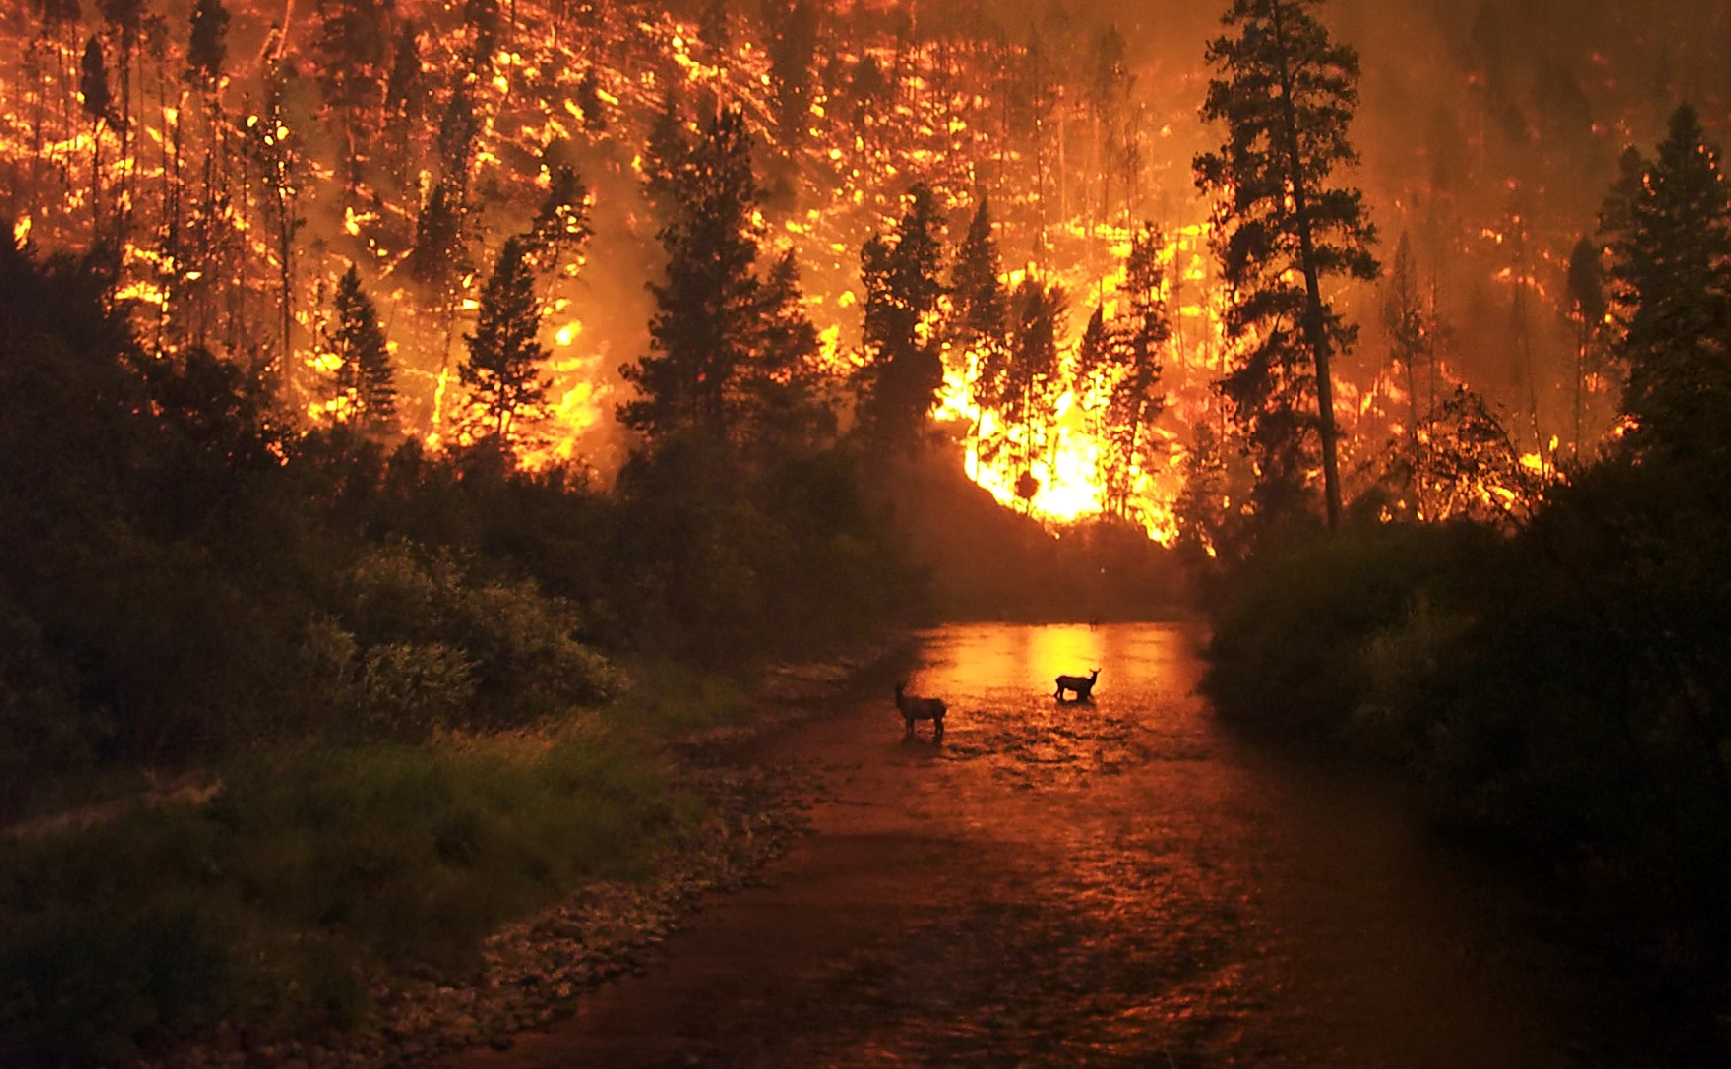

In [24]:
#loading the image
img = image.load_img('predict.jpg')
img

# Resizing the image

In [25]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


# Making the prediction

In [26]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  0 and the predicted label is: fire


# Saving the model

In [27]:
tf.saved_model.save(model2, 'saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


# Converting the model to be used on tflite interpreter on Raspberry PI Zero

In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model') # path to the SavedModel directory
tflite_model = converter.convert()


# Saving the tflite model in the local directory

In [29]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)